## SBTi Target Status


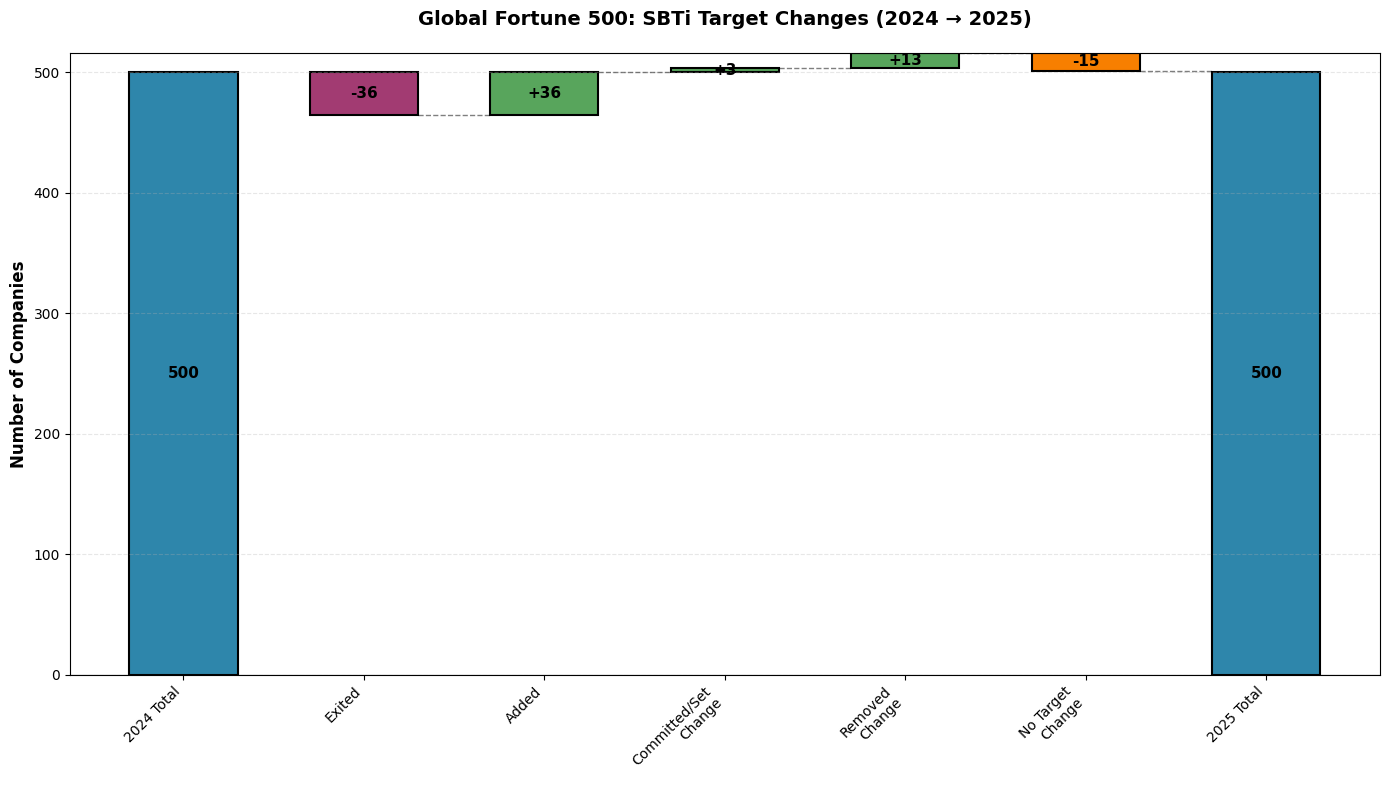

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
exited = len(companies_2024 - companies_2025)
added = len(companies_2025 - companies_2024)

# Map SBTi target status
def map_status(row, year):
    if year == 2024:
        status = str(row['Target status - NT']).strip()
    else:
        status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    
    if status in ['Targets Set', 'Targets set', 'Committed', 'T', 'C']:
        return 'Committed/Set'
    elif status in ['Removed', 'Commitment removed', 'R']:
        return 'Removed'
    else:
        return 'No Target'

# Count statuses
status_2024 = df_2024.apply(lambda row: map_status(row, 2024), axis=1).value_counts().to_dict()
status_2025 = df_2025.apply(lambda row: map_status(row, 2025), axis=1).value_counts().to_dict()

# Build waterfall data
categories = ['2024 Total', 'Exited', 'Added']
values = [500, -exited, added]
colors = ['#2E86AB', '#A23B72', '#58A55C']

for status in ['Committed/Set', 'Removed', 'No Target']:
    change = status_2025.get(status, 0) - status_2024.get(status, 0)
    if change != 0:
        categories.append(f'{status}\nChange')
        values.append(change)
        colors.append('#58A55C' if change > 0 else '#F77F00')

categories.append('2025 Total')
values.append(500)
colors.append('#2E86AB')

# Calculate cumulative positions
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot waterfall
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: SBTi Target Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:

pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 8.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [nbformat]5/6 [nbformat]a]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import plotly.graph_objects as go

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Map SBTi status
def map_status(row, year):
    if year == 2024:
        status = str(row['Target status - NT']).strip()
    else:
        status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    
    if status in ['Targets Set', 'Targets set', 'Committed', 'T', 'C']:
        return 'Committed/Set'
    elif status in ['Removed', 'Commitment removed', 'R']:
        return 'Removed'
    else:
        return 'No Target'

# Create status mappings for continuing companies
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Count transitions
transitions = {}
for company in continuing:
    old_status = map_status(df_2024_indexed.loc[company], 2024)
    new_status = map_status(df_2025_indexed.loc[company], 2025)
    key = (old_status, new_status)
    transitions[key] = transitions.get(key, 0) + 1

# Build Sankey
labels = ['2024: Committed/Set', '2024: Removed', '2024: No Target',
          '2025: Committed/Set', '2025: Removed', '2025: No Target']

source = []
target = []
value = []
colors = []

label_map = {'Committed/Set': 0, 'Removed': 1, 'No Target': 2}
color_map = {
    (0, 3): '#58A55C', (0, 4): '#F77F00', (0, 5): '#F77F00',
    (1, 3): '#58A55C', (1, 4): '#A23B72', (1, 5): '#A23B72',
    (2, 3): '#58A55C', (2, 4): '#F77F00', (2, 5): '#2E86AB'
}

for (old, new), count in transitions.items():
    src = label_map[old]
    tgt = label_map[new] + 3
    source.append(src)
    target.append(tgt)
    value.append(count)
    colors.append(color_map.get((src, tgt), '#CCCCCC'))

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        color=['#2E86AB', '#A23B72', '#666666', '#2E86AB', '#A23B72', '#666666']
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=colors
    )
)])

fig.update_layout(
    title_text="SBTi Target Transitions (2024 → 2025)",
    font_size=12,
    height=600
)

fig.write_html('sankey_chart.html')

In [16]:
import pandas as pd

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Map SBTi status
def map_status(row, year):
    if year == 2024:
        status = str(row['Target status - NT']).strip()
    else:
        status = str(row['Target status (T = target set, C = committed, N=No, R=Removed)']).strip()
    
    if status in ['Targets Set', 'Targets set', 'Committed', 'T', 'C']:
        return 'Committed/Set'
    elif status in ['Removed', 'Commitment removed', 'R']:
        return 'Removed'
    else:
        return 'No Target'

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())

exited = companies_2024 - companies_2025
added = companies_2025 - companies_2024
continuing = companies_2024 & companies_2025

# Track status changes
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

changes = []
for company in continuing:
    old_status = map_status(df_2024_indexed.loc[company], 2024)
    new_status = map_status(df_2025_indexed.loc[company], 2025)
    if old_status != new_status:
        changes.append({'Company': company, '2024': old_status, '2025': new_status})

# Create DataFrames
df_exited = pd.DataFrame({'Company': list(exited)})
df_added = pd.DataFrame({'Company': list(added)})
df_changes = pd.DataFrame(changes)

# Save to Excel
with pd.ExcelWriter('company_changes.xlsx') as writer:
    df_exited.to_excel(writer, sheet_name='Exited', index=False)
    df_added.to_excel(writer, sheet_name='Added', index=False)
    df_changes.to_excel(writer, sheet_name='Status Changes', index=False)

print(f"Exited companies: {len(exited)}")
print(f"Added companies: {len(added)}")
print(f"Companies with status changes: {len(changes)}")

Exited companies: 36
Added companies: 36
Companies with status changes: 39


## RE100

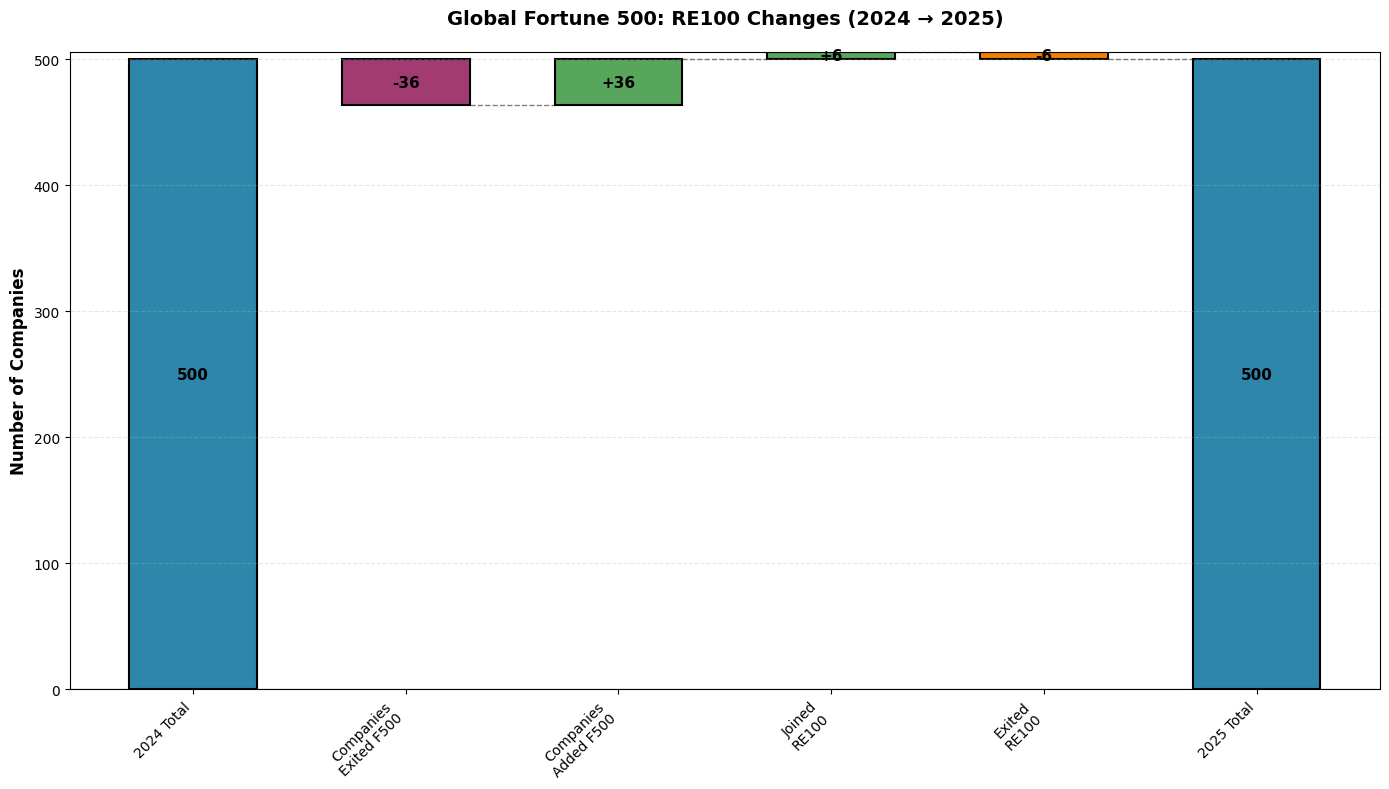

Joined RE100: 6
['Tongwei Group', 'Hon Hai Precision Industry', 'SK', 'Chevron', 'La Poste', 'Commonwealth Bank of Australia']

Exited RE100: 6
['Daiwa House Industry', 'Meta Platforms', 'Capital One Financial', 'Morgan Stanley', 'Siemens', 'Procter & Gamble']


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Map RE100 status
def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

# Track changes for continuing companies
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

joined = []
exited_re = []

for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    if old == 'Not in RE100' and new == 'In RE100':
        joined.append(company)
    elif old == 'In RE100' and new == 'Not in RE100':
        exited_re.append(company)

# Build waterfall
categories = ['2024 Total', 'Companies\nExited F500', 'Companies\nAdded F500', 
              'Joined\nRE100', 'Exited\nRE100', '2025 Total']
values = [500, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), 
          len(joined), -len(exited_re), 500]
colors = ['#2E86AB', '#A23B72', '#58A55C', '#58A55C', '#F77F00', '#2E86AB']

# Calculate cumulative
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: RE100 Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_re100.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Joined RE100: {len(joined)}")
print(joined)
print(f"\nExited RE100: {len(exited_re)}")
print(exited_re)

In [22]:
import pandas as pd
import plotly.graph_objects as go

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Map RE100 status
def map_re100(row):
    status = str(row['RE100 (Y/N)']).strip()
    return 'In RE100' if status in ['Yes', 'Y'] else 'Not in RE100'

# Get continuing companies
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Count transitions
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

transitions = {}
for company in continuing:
    old = map_re100(df_2024_indexed.loc[company])
    new = map_re100(df_2025_indexed.loc[company])
    key = (old, new)
    transitions[key] = transitions.get(key, 0) + 1

# Build Sankey
labels = ['2024: In RE100', '2024: Not in RE100', '2025: In RE100', '2025: Not in RE100']
label_map = {'In RE100': 0, 'Not in RE100': 1}

source = []
target = []
value = []

for (old, new), count in transitions.items():
    source.append(label_map[old])
    target.append(label_map[new] + 2)
    value.append(count)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        color=['#2E86AB', '#666666', '#2E86AB', '#666666']
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(
    title_text="RE100 Status Transitions (2024 → 2025)",
    font_size=12,
    height=600
)

fig.write_html('sankey_re100.html')

## Carbon Credits


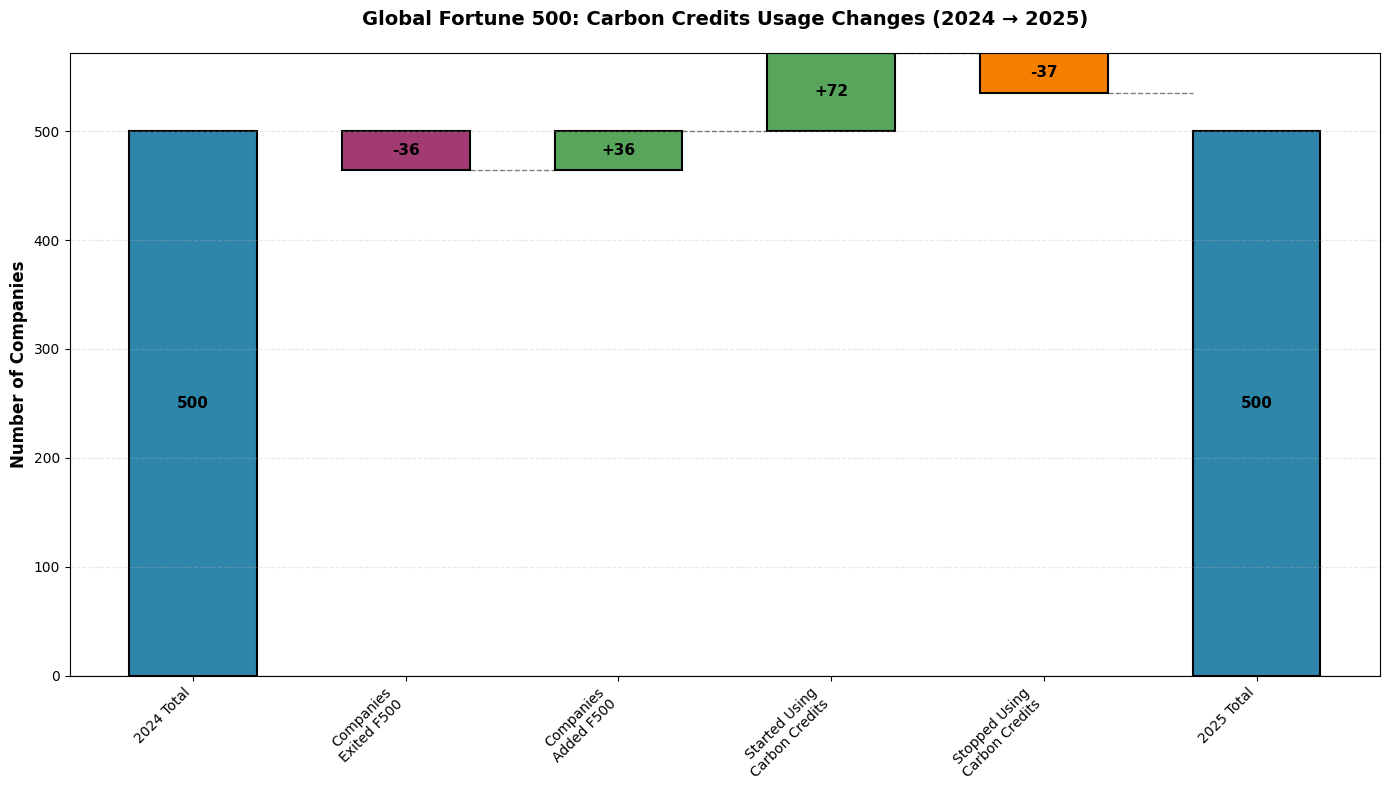

Started using: 72
['Marathon Petroleum', 'Liberty Mutual Insurance Group', 'Lennar', 'Cardinal Health', 'PDD Holdings', 'Pacific Construction Group', 'Hunan Iron & Steel Group', 'X5 Retail Group', 'China Minsheng Banking', 'Home Depot', 'VTB Bank', 'Shandong Hi-Speed Group', 'Dongfeng Motor', 'Tata Motors', 'Humana', 'PowerChina', 'Paccar', 'BNP Paribas', 'China Huaneng Group', 'Kia', 'World Kinect', "People's Insurance Co. of China", 'CHS', 'TongLing Nonferrous Metals Group', 'Haier Smart Home', 'JD.com', 'Archer Daniels Midland', 'Deere', 'Publix Super Markets', 'Huawei Investment & Holding', 'Roche Group', 'Louis Dreyfus', 'HD Hyundai', 'Abbott Laboratories', 'Industrial Bank', 'Warner Bros. Discovery', 'Dollar General', 'Broadcom', 'Gazprom', 'Guangxi Investment Group', 'Freddie Mac', 'SAIC Motor', 'Oil & Natural Gas', 'China Railway Construction', 'CITIC Group', 'Bouygues', 'China Life Insurance', 'Mizuho Financial Group', 'Cencora', 'State Farm Insurance', 'Costco Wholesale', 'Li

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Map carbon credits status
def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U']:
        return 'Uses Carbon Credits'
    return 'No Carbon Credits'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified']:
        return 'Uses Carbon Credits'
    return 'No Carbon Credits'

# Track changes
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

started_using = []
stopped_using = []

for company in continuing:
    old = map_cc_2024(df_2024_indexed.loc[company])
    new = map_cc_2025(df_2025_indexed.loc[company])
    if old == 'No Carbon Credits' and new == 'Uses Carbon Credits':
        started_using.append(company)
    elif old == 'Uses Carbon Credits' and new == 'No Carbon Credits':
        stopped_using.append(company)

# Build waterfall
categories = ['2024 Total', 'Companies\nExited F500', 'Companies\nAdded F500', 
              'Started Using\nCarbon Credits', 'Stopped Using\nCarbon Credits', '2025 Total']
values = [500, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), 
          len(started_using), -len(stopped_using), 500]
colors = ['#2E86AB', '#A23B72', '#58A55C', '#58A55C', '#F77F00', '#2E86AB']

# Calculate cumulative
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Credits Usage Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_carbon_credits.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Started using: {len(started_using)}")
print(started_using)
print(f"\nStopped using: {len(stopped_using)}")
print(stopped_using)
changes = []
for company in continuing:
    old = map_cc_2024(df_2024_indexed.loc[company])
    new = map_cc_2025(df_2025_indexed.loc[company])
    if old != new:
        changes.append({'Company': company, '2024': old, '2025': new})

df_changes = pd.DataFrame(changes)
df_changes.to_excel('carbon_credits_changes.xlsx', index=False)

In [26]:
import pandas as pd
import plotly.graph_objects as go

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Map carbon credits
def map_cc_2024(row):
    cc1 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear)']).strip()
    cc2 = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc1 in ['Y', 'R', 'U'] or cc2 in ['Y', 'R', 'U'] else 'No CC'

def map_cc_2025(row):
    cc = str(row['Carbon credits (Y = yes, N = no, R = removals only, U = unclear).1']).strip()
    return 'Uses CC' if cc in ['Yes', 'Y', 'R', 'U', 'Not Specified'] else 'No CC'

# Get continuing companies
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

# Count transitions
transitions = {}
for company in continuing:
    old = map_cc_2024(df_2024_indexed.loc[company])
    new = map_cc_2025(df_2025_indexed.loc[company])
    transitions[(old, new)] = transitions.get((old, new), 0) + 1

# Build Sankey
labels = ['2024: Uses CC', '2024: No CC', '2025: Uses CC', '2025: No CC']
label_map = {'Uses CC': 0, 'No CC': 1}

source, target, value = [], [], []
for (old, new), count in transitions.items():
    source.append(label_map[old])
    target.append(label_map[new] + 2)
    value.append(count)

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=labels, color=["#F49DE0", "#605493", "#86ACE1", "#B1D295"]),
    link=dict(source=source, target=target, value=value)
)])

fig.update_layout(title_text="Carbon Credits Usage Transitions (2024 → 2025)", font_size=12, height=600)
fig.write_html('sankey_carbon_credits.html')

## Carbon Neutral 


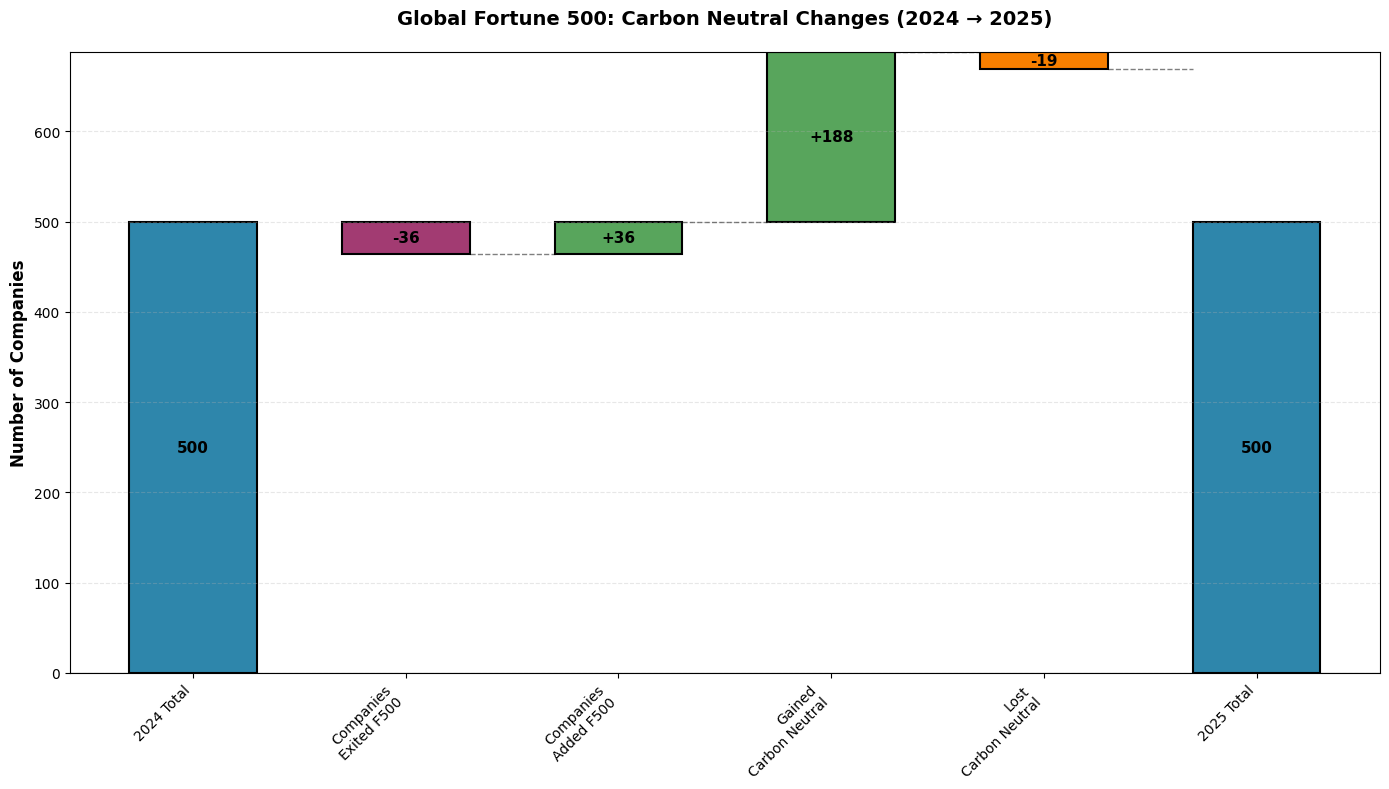

Gained: 188
['Marathon Petroleum', 'Qualcomm', 'KB Financial Group', 'Liberty Mutual Insurance Group', 'Coca-Cola', 'Zhejiang Hengyi Group', 'Ecopetrol', 'ABB', 'MS&AD Insurance Group Holdings', 'Cardinal Health', 'Olam Group', 'BHP Group', 'Greenland Holding Group', 'United Airlines Holdings', 'Meta Platforms', 'AbbVie', 'Pacific Construction Group', 'New York Life Insurance', 'Home Depot', 'Performance Food Group', 'VTB Bank', 'Vodafone Group', 'Indian Oil', 'UBS Group', 'Shandong Hi-Speed Group', 'Hailiang Group', 'Netflix', 'Unilever', 'Allstate', 'Northrop Grumman', 'Pertamina', 'Northwestern Mutual', 'Woolworths Group', 'American Airlines Group', 'Veolia Environnement', 'Edeka Zentrale', 'Hon Hai Precision Industry', 'Vale', 'XMXYG', 'Walmart', 'Bristol-Myers Squibb', 'Tata Motors', 'Enel', 'Humana', 'Maersk Group', 'TIAA', 'Paccar', 'Salesforce', 'UnitedHealth Group', "Lowe's", 'Shell', 'Mitsubishi Heavy Industries', 'Intel', 'Air France-KLM Group', 'Cummins', 'Guangzhou Pharmac

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_2024 = pd.read_csv('gf5002024.csv', encoding='latin-1')
df_2025 = pd.read_csv('gf5002026.csv', encoding='latin-1')

# Get company sets
companies_2024 = set(df_2024['Company Name'].dropna())
companies_2025 = set(df_2025['Company Name'].dropna())
continuing = companies_2024 & companies_2025

# Map CN status
def map_cn_2024(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S = subsidiary, U = unspecified, x = less than 50% of rev, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

def map_cn_2025(row):
    cn = str(row['Carbon neutral commitment (C = company, V = value chain, G= Government, S=Subsidiary,  U = unspecified, N=no)']).strip()
    return 'Has CN' if cn not in ['N', 'nan'] else 'No CN'

# Track changes
df_2024_indexed = df_2024.set_index('Company Name')
df_2025_indexed = df_2025.set_index('Company Name')

gained_cn = []
lost_cn = []

for company in continuing:
    old = map_cn_2024(df_2024_indexed.loc[company])
    new = map_cn_2025(df_2025_indexed.loc[company])
    if old == 'No CN' and new == 'Has CN':
        gained_cn.append(company)
    elif old == 'Has CN' and new == 'No CN':
        lost_cn.append(company)

# Build waterfall
categories = ['2024 Total', 'Companies\nExited F500', 'Companies\nAdded F500', 
              'Gained\nCarbon Neutral', 'Lost\nCarbon Neutral', '2025 Total']
values = [500, -len(companies_2024 - companies_2025), len(companies_2025 - companies_2024), 
          len(gained_cn), -len(lost_cn), 500]
colors = ['#2E86AB', '#A23B72', '#58A55C', '#58A55C', '#F77F00', '#2E86AB']

# Calculate cumulative
cumulative = [0]
for i, val in enumerate(values[:-1]):
    cumulative.append(val if i == 0 else cumulative[-1] + val)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, (cat, val, col) in enumerate(zip(categories, values, colors)):
    if i == 0 or i == len(categories) - 1:
        ax.bar(i, val, color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = val / 2
        label = f'{val}'
    else:
        ax.bar(i, val, bottom=cumulative[i], color=col, width=0.6, edgecolor='black', linewidth=1.5)
        label_pos = cumulative[i] + val / 2
        label = f'{val:+d}'
        if i < len(categories) - 1:
            ax.plot([i + 0.3, i + 0.7], [cumulative[i+1], cumulative[i+1]], 'k--', linewidth=1, alpha=0.5)
    
    ax.text(i, label_pos, label, ha='center', va='center', fontsize=11, fontweight='bold')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Companies', fontsize=12, fontweight='bold')
ax.set_title('Global Fortune 500: Carbon Neutral Changes (2024 → 2025)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('waterfall_carbon_neutral.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Gained: {len(gained_cn)}")
print(gained_cn)
print(f"\nLost: {len(lost_cn)}")
print(lost_cn)

# Save changes to Excel
changes = []
for company in continuing:
    old = map_cn_2024(df_2024_indexed.loc[company])
    new = map_cn_2025(df_2025_indexed.loc[company])
    if old != new:
        changes.append({'Company': company, '2024': old, '2025': new})

df_changes = pd.DataFrame(changes)
df_changes.to_excel('carbon_neutral_changes.xlsx', index=False)